In [18]:
# Install dependencies.
!pip install pywaffle 

Defaulting to user installation because normal site-packages is not writeable


In [19]:
'''
This is a performance comparison between cold queries (without cache)
and warm queries (with cache) based on the Apache JMeter benchmark results.

The TPC-DS benchmark data for Dremio was generated according to this guide:
https://www.dremio.com/blog/dremio-benchmarking-methodology

Benchmark result files could be loaded from the project repo:
https://github.com/aabouzaid/modern-data-platform-poc/tree/main/benchmark
'''
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO as sio
from matplotlib.offsetbox import AnchoredText as obat
from pywaffle import Waffle

dataset_size = '100g'
dremio_version = '24.0.0'
plot_main_title = f'TPC-DS queries benchmark for Dremio v{dremio_version} - Dataset {dataset_size}'

In [20]:
# --------------- #
# Load
# --------------- #

#
# Cold.
# 

# Load benchmark data from files.
df_cold_run01 = pd.read_csv(f'./results/{dataset_size}/run01/dremio-v{dremio_version}-tpc-ds-{dataset_size}-cold.csv', usecols=['elapsed', 'label'])
df_cold_run02 = pd.read_csv(f'./results/{dataset_size}/run02/dremio-v{dremio_version}-tpc-ds-{dataset_size}-cold.csv', usecols=['elapsed', 'label'])
df_cold_run03 = pd.read_csv(f'./results/{dataset_size}/run03/dremio-v{dremio_version}-tpc-ds-{dataset_size}-cold.csv', usecols=['elapsed', 'label'])

# Combine the three runs into one.
df_combined = pd.concat([df_cold_run01, df_cold_run02, df_cold_run03])

# Group by 'label' and calculate the mean of 'elapsed' for each group.
df_cold = df_combined.groupby('label')['elapsed'].mean().round(0).astype(int).reset_index()

#
# Warm.
#

# Load benchmark data from files.
df_warm_run01 = pd.read_csv(f'./results/{dataset_size}/run01/dremio-v{dremio_version}-tpc-ds-{dataset_size}-warm.csv', usecols=['elapsed', 'label'])
df_warm_run02 = pd.read_csv(f'./results/{dataset_size}/run02/dremio-v{dremio_version}-tpc-ds-{dataset_size}-warm.csv', usecols=['elapsed', 'label'])
df_warm_run03 = pd.read_csv(f'./results/{dataset_size}/run03/dremio-v{dremio_version}-tpc-ds-{dataset_size}-warm.csv', usecols=['elapsed', 'label'])

# Combine the three runs into one.
df_combined = pd.concat([df_warm_run01, df_warm_run02, df_warm_run03])

# Group by 'label' and calculate the mean of 'elapsed' for each group.
df_warm = df_combined.groupby('label')['elapsed'].mean().round(2).astype(int).reset_index()

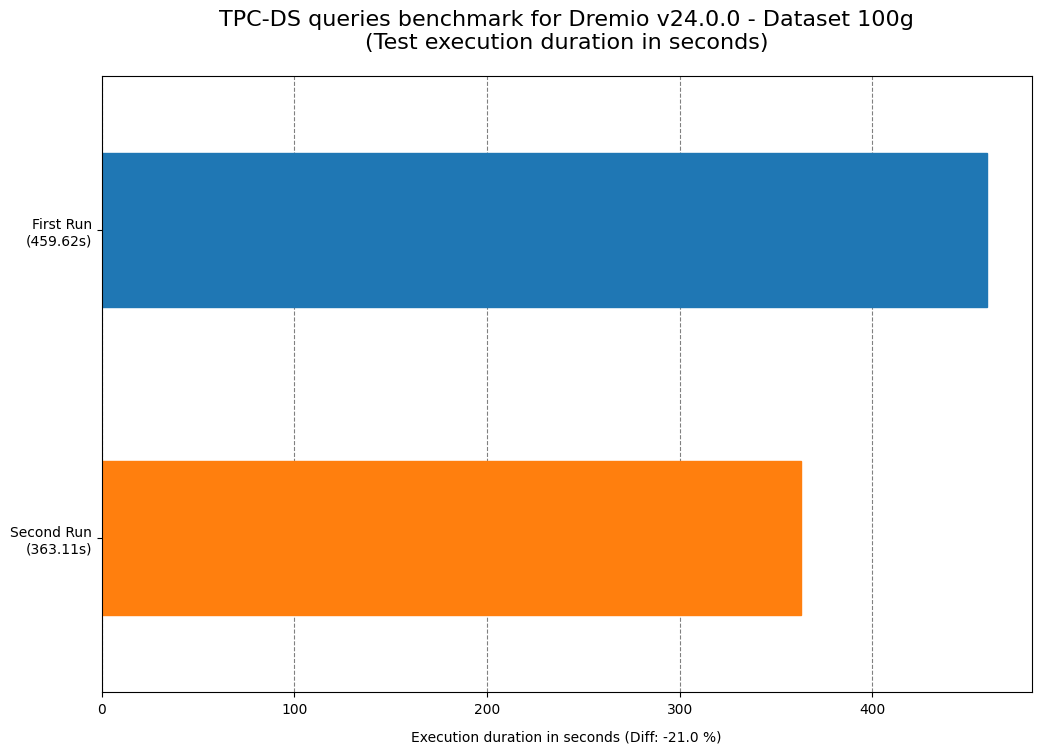

In [21]:
# Get details about the test execution duration.
exec_duration_cold_sec = (df_cold['elapsed'].sum() / 1000).round(2)
exec_duration_warm_sec = (df_warm['elapsed'].sum() / 1000).round(2)

exec_duration_cold_sec
exec_duration_warm_sec


# Create a dataframe for test execution duration.
exec_duration_df = pd.DataFrame({
    'exec': [
        f'First Run\n({exec_duration_cold_sec}s)',
        f'Second Run\n({exec_duration_warm_sec}s)'
    ],
    'duration_sec': [exec_duration_cold_sec, exec_duration_warm_sec]
})

# Calculate percentage differences between the first and the second run.
exec_duration_diff_pct = exec_duration_df[['duration_sec']].pct_change()['duration_sec'].iloc[1].round(2) * 100

#-------------------------#
# Plot execution duration #
#-------------------------#

exec_duration = exec_duration_df.plot.barh(x='exec', y='duration_sec', legend=False, figsize=(12, 8))
exec_duration.invert_yaxis()
exec_duration.set_title(f'{plot_main_title}\n(Test execution duration in seconds)', pad=20, size=16)
exec_duration.set_xlabel(f'Execution duration in seconds (Diff: {exec_duration_diff_pct} %)', labelpad=10)
exec_duration.set_ylabel('')
exec_duration.xaxis.grid(color='gray', linestyle='dashed')
exec_duration.set_axisbelow(True)
for color, bar in zip(['tab:blue', 'tab:orange'], exec_duration.patches):
    bar.set_color(color)

In [22]:
# --------------- #
# Prepare
# --------------- #

# Merge cold and warm benchmark results in one dataframe.
df_combined = df_cold.merge(df_warm, on='label', how='left', suffixes=('_cold', '_warm'))

# Calculate percentage enhancement between cold and warm results.
df_combined['elapsed_diff_pct'] = ((df_combined[['elapsed_cold', 'elapsed_warm']].pct_change(axis=1)['elapsed_warm']) * 100).round(2)

# Create a new dataframe with elapsed time in seconds (JMeter's elapsed time unit is in milliseconds).
df_cleaned = pd.DataFrame({
        'duration_cold_sec': df_combined['elapsed_cold'].apply(lambda x: x / 1000).tolist(),
        'duration_warm_sec': df_combined['elapsed_warm'].apply(lambda x: x / 1000).tolist(),
        'duration_diff_pct': df_combined['elapsed_diff_pct'].tolist(),
    },
    index=df_combined['label']
)

/tmp/ipykernel_2589310/2124493683.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_combined['elapsed_diff_pct'] = ((df_combined[['elapsed_cold', 'elapsed_warm']].pct_change(axis=1)['elapsed_warm']) * 100).round(2)


In [32]:
print(df_cleaned.sample(5).to_csv(sep="\t"))

label	duration_cold_sec	duration_warm_sec	duration_diff_pct	label_diff_pct
q7	42.293	34.041	-19.51	q7 (diff: -19.51%)
q71	15.017	13.685	-8.87	q71 (diff: -8.87%)
q63	17.296	13.226	-23.53	q63 (diff: -23.53%)
q91	6.089	1.396	-77.07	q91 (diff: -77.07%)
q84	6.201	4.271	-31.12	q84 (diff: -31.12%)



In [24]:
# --------------- #
# Plot
# --------------- #

plt.rcParams.update({
    # Set background for all plots.
    "figure.facecolor": 'white'
})

Text(0.5, 0.98, 'TPC-DS queries benchmark for Dremio v24.0.0 - Dataset 100g\n(Status of the TPC-DS 99 queries)')

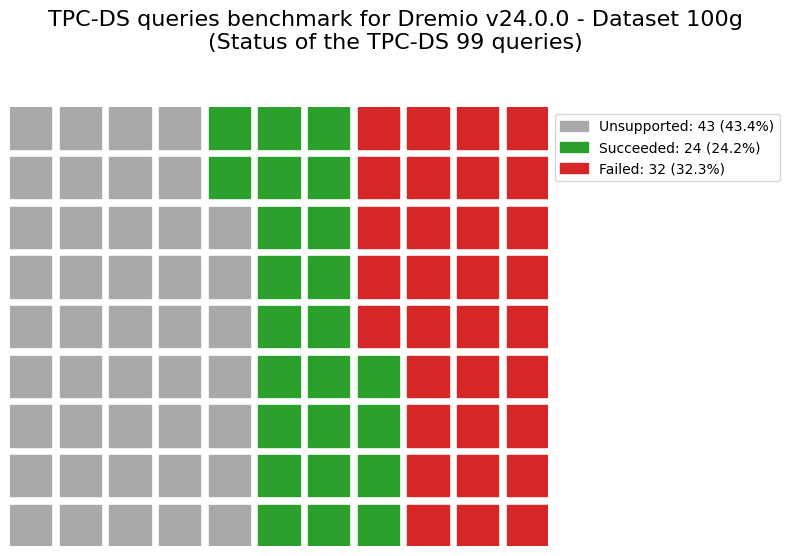

In [25]:
#--------------------------#
# Plot TPC-DS tests status #
#--------------------------#

tpcds_tests_status = pd.read_csv(f'./results/{dataset_size}/tpcds_tests_status_{dataset_size}.csv').iloc[0]

tpcds_tests_data = {
    'Unsupported': tpcds_tests_status['unsupported'],
    'Succeeded':tpcds_tests_status['succeeded'],
    'Failed': tpcds_tests_status['failed']
}

tpcds_tests_labels = [f"{k}: {v} ({v / 99 * 100:.1f}%)" for k, v in tpcds_tests_data.items()]

tpcds_tests = plt.figure(
    FigureClass=Waffle,
    figsize=(8, 6),
    rows=9,
    columns=11,
    values=tpcds_tests_data,
    labels=tpcds_tests_labels,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=["darkgray", 'tab:green', 'tab:red'],
)

tpcds_tests.suptitle(f'{plot_main_title}\n(Status of the TPC-DS 99 queries)', fontsize=16)

Text(0, 0.5, '')

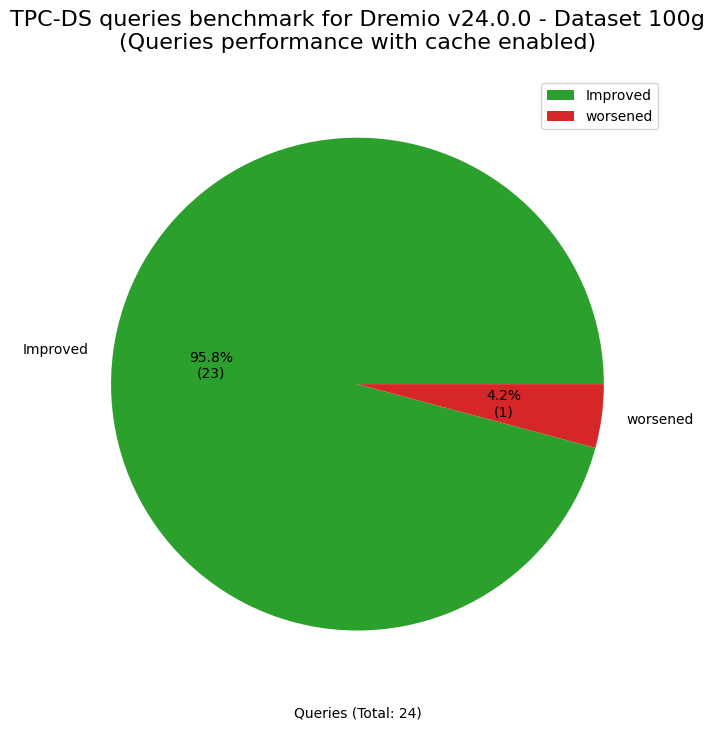

In [26]:
#---------------------------------------------#
# Plot queries performance with cache enabled #
#---------------------------------------------#

query_performance_df = pd.DataFrame({
        'queries': [len(df_cleaned[df_cleaned['duration_diff_pct'] < 0]),
                  len(df_cleaned[df_cleaned['duration_diff_pct'] > 0])],
    },
    index=['Improved', 'worsened']
)

# Show the percentage and actual value at the same time.
def autopct_format(pct):
    total = sum(query_performance_df['queries'])
    return '{:.1f}%\n({:.0f})'.format(pct, total * pct / 100)

query_performance = query_performance_df.plot.pie(y='queries', colors=['tab:green', 'tab:red'], autopct=autopct_format, figsize=(12, 8))
query_performance.set_title(f'{plot_main_title}\n(Queries performance with cache enabled)', pad=20, size=16)
query_performance.set_xlabel(f'Queries (Total: {query_performance_df["queries"].sum()})', labelpad=10)
query_performance.set_ylabel('')

/tmp/ipykernel_2589310/1215337948.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff_pct.text(index-0.8, diff_pct_df[index]+0.8, '{0:.3g}%'.format(diff_pct_df[index]), horizontalalignment='center', rotation=-25)


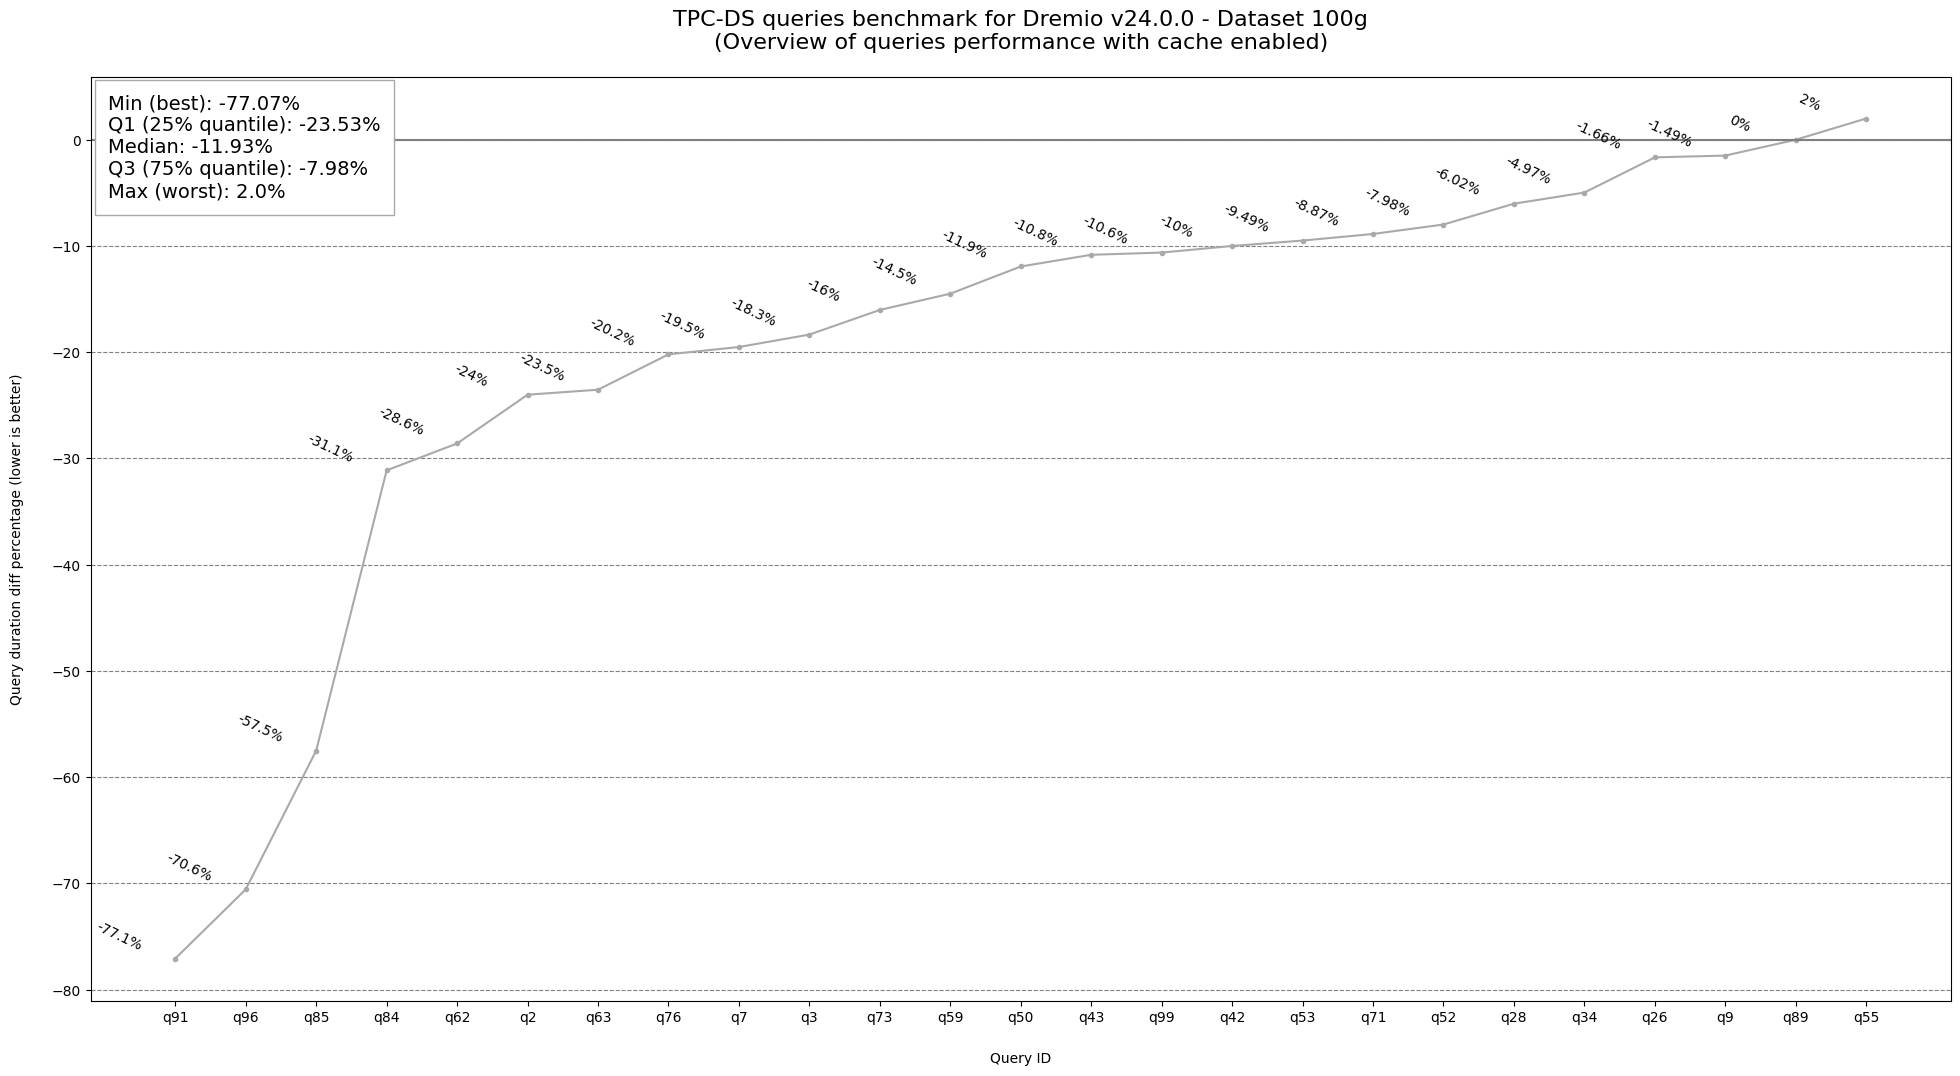

In [27]:
#-------------------------------------------------------------#
# Plot overview of the queries performance with cache enabled #
#-------------------------------------------------------------#

diff_pct_df = df_cleaned.sort_values(by=['duration_diff_pct'])['duration_diff_pct']
diff_pct = diff_pct_df.plot.line(color='darkgray', style='.-', rot=0, figsize=(24, 12))
diff_pct.yaxis.grid(color='gray', linestyle='dashed')
diff_pct.set_axisbelow(True)
diff_pct.set_title(f'{plot_main_title}\n(Overview of queries performance with cache enabled)', pad=20, size=16)
diff_pct.set_xlabel('Query ID', labelpad=20)
diff_pct.set_ylabel('Query duration diff percentage (lower is better)', labelpad=20)
xticks = range(diff_pct_df.count())
diff_pct.set_xticks(xticks)
diff_pct.set_xticklabels(diff_pct_df.index.tolist())
diff_pct.axhline(0, color='gray')
for index in xticks:
    diff_pct.text(index-0.8, diff_pct_df[index]+0.8, '{0:.3g}%'.format(diff_pct_df[index]), horizontalalignment='center', rotation=-25)

# Add summary box.
diff_pct_stat = (
    f'Min (best): {diff_pct_df.min()}%\n'
    f'Q1 (25% quantile): {diff_pct_df.quantile(0.25)}%\n'
    f'Median: {diff_pct_df.median()}%\n'
    f'Q3 (75% quantile): {diff_pct_df.quantile(0.75)}%\n'
    f'Max (worst): {diff_pct_df.max()}%'
)
diff_pct_details = obat(diff_pct_stat, prop=dict(size=14), frameon=True, loc='upper left')
diff_pct_details.patch.set(boxstyle='square', edgecolor='darkgray')
diff_pct.add_artist(diff_pct_details)

Text(0, 0.5, '')

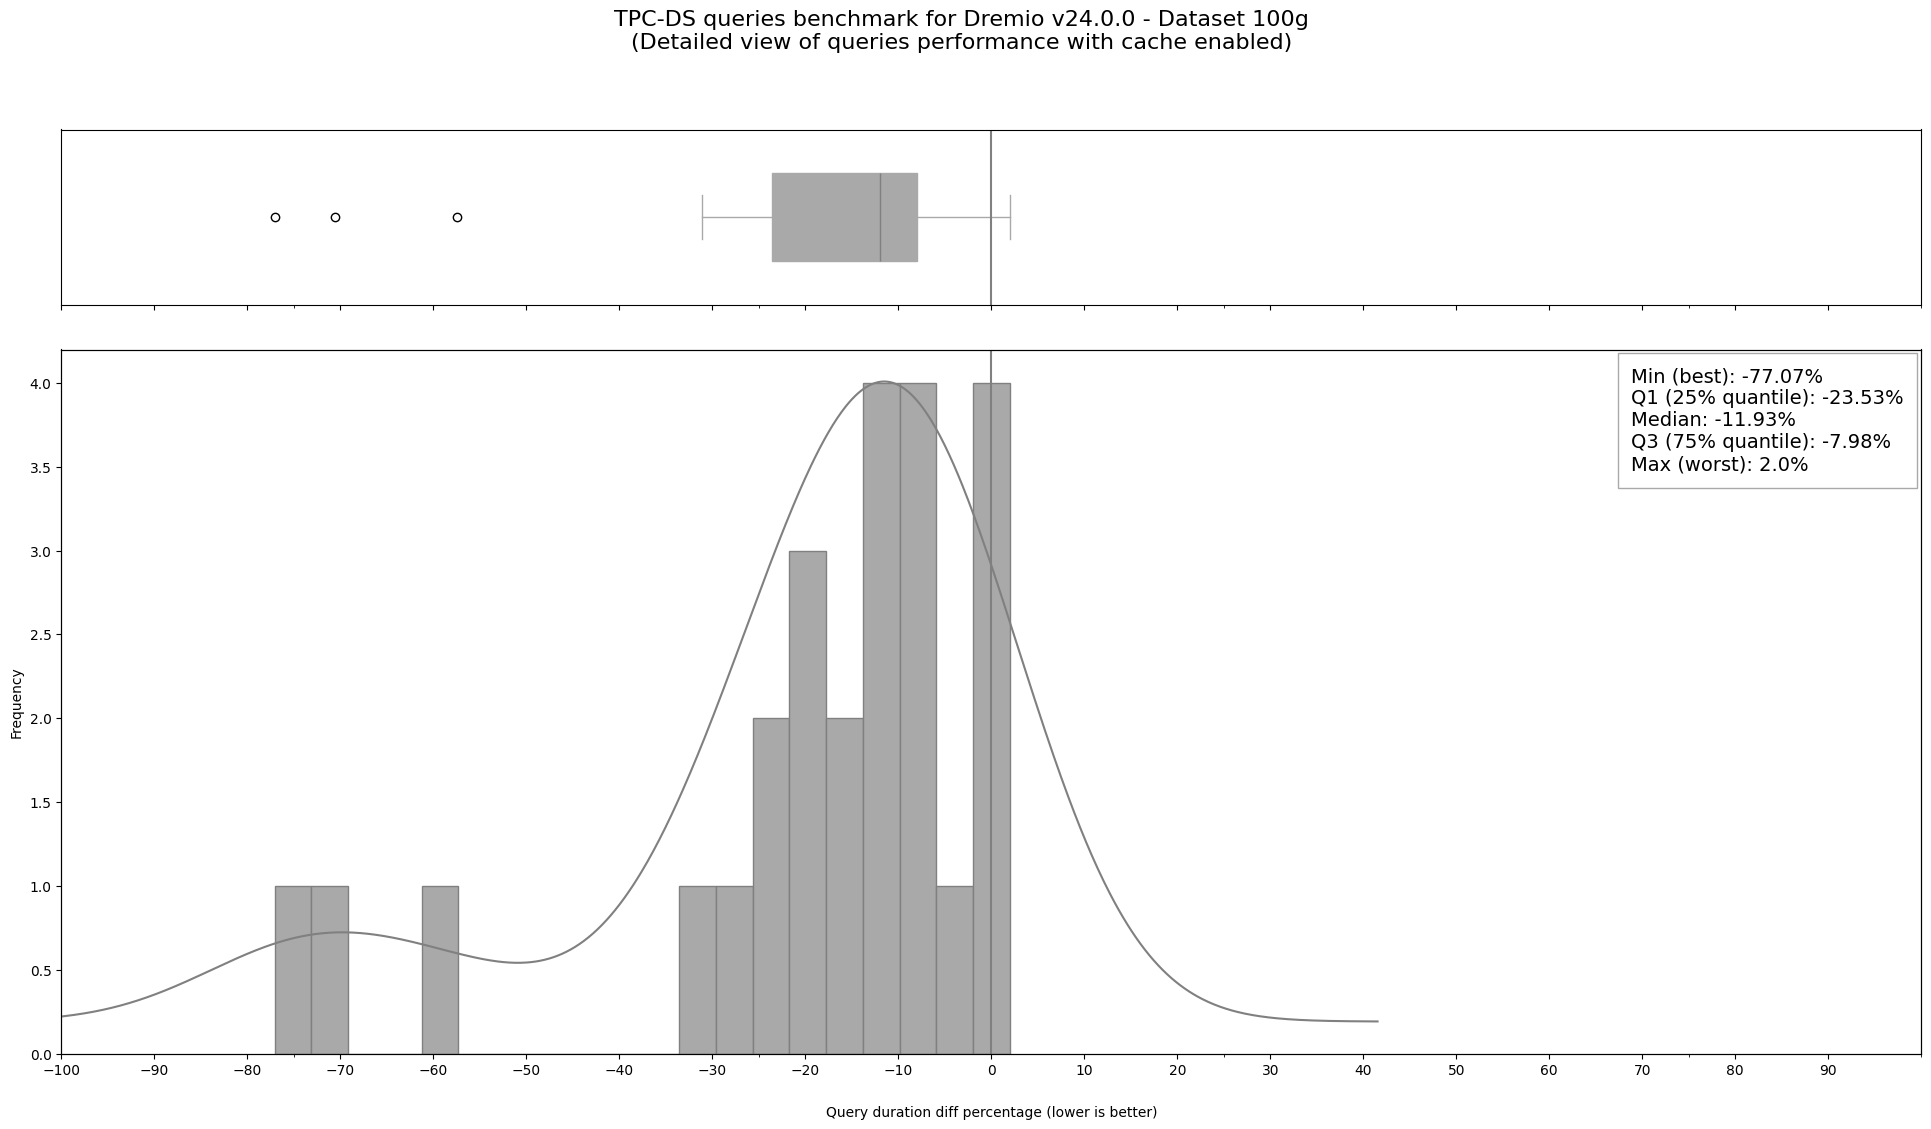

In [28]:
#---------------------------------------#
# Plot queries performance distribution #
#---------------------------------------#

# Base.
fig, ax = plt.subplots(2, figsize=(24, 12), sharex=True, gridspec_kw={"height_ratios": (.2, .8)})
fig.suptitle(f'{plot_main_title}\n(Detailed view of queries performance with cache enabled)', size=16)
plt.subplots_adjust(hspace=0.1)

# Summary.
diff_pct_details = obat(diff_pct_stat, prop=dict(size=14), frameon=True, loc='upper right')
diff_pct_details.patch.set(boxstyle='square', edgecolor='darkgray')
ax[1].add_artist(diff_pct_details)

# Boxplot.
diff_pct_box = diff_pct_df.plot.box(color='darkgray', vert=False, medianprops={'color': 'gray'}, patch_artist=True, widths = 0.5, ax=ax[0])
diff_pct_box.axvline(0, color='gray')
diff_pct_box.set_yticks([])

# Histogram.
diff_pct_hist = diff_pct_df.plot.hist(color='darkgray', edgecolor='gray', bins=20, xlim=[-100, 100], ax=ax[1])
diff_pct_hist.set_xticks(range(-100, 100, 10))
diff_pct_hist.axvline(0, color='gray')
diff_pct_hist.set_xlabel('Query duration diff percentage (lower is better)', labelpad=20)

# Distribution line.
diff_pct_kde = diff_pct_df.plot.kde(color='gray', ax=diff_pct_hist.twinx())
diff_pct_kde.set_yticks([])
diff_pct_kde.set_ylabel('')

In [29]:
# Set labels with percentage enhancement to make it easy to plot bars.
df_cleaned['label_diff_pct'] = df_cleaned.assign(label=df_cleaned.index)[['label', 'duration_diff_pct']].apply(
    lambda x : f'{x[0]} (diff: {x[1]}%)', axis=1)
df_cleaned.head()

/tmp/ipykernel_2589310/2949061757.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x : f'{x[0]} (diff: {x[1]}%)', axis=1)


,duration_cold_sec,duration_warm_sec,duration_diff_pct,label_diff_pct
label,,,,
q2,19.724,14.990,-24.00,q2 (diff: -24.0%)
q26,5.733,5.638,-1.66,q26 (diff: -1.66%)
q28,44.009,41.359,-6.02,q28 (diff: -6.02%)
q3,10.488,8.564,-18.34,q3 (diff: -18.34%)
q34,9.549,9.074,-4.97,q34 (diff: -4.97%)


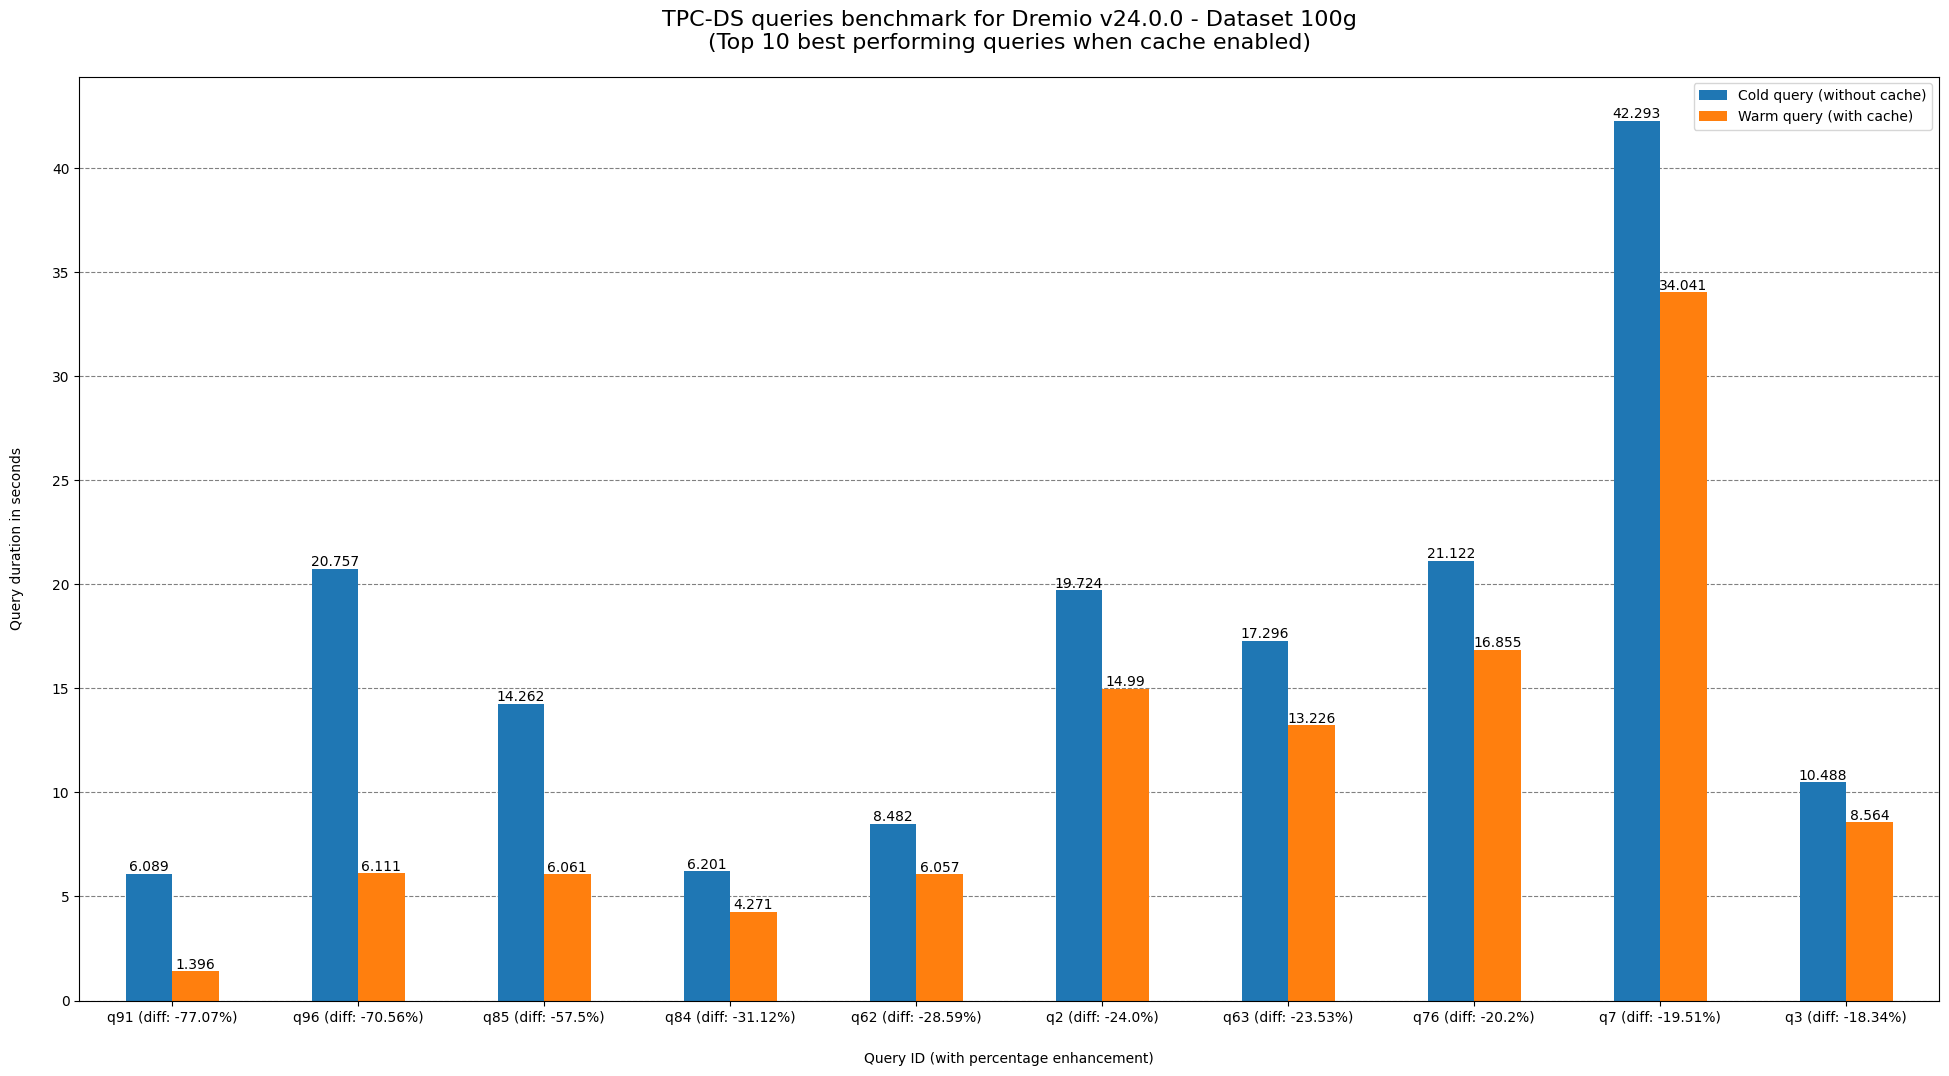

In [30]:
#-----------------------------------------#
# Plot the best 10 queries by using cache #
#-----------------------------------------#

best_queries_df = df_cleaned.nsmallest(10, 'duration_diff_pct')
best_queries = best_queries_df.plot.bar(y=['duration_cold_sec', 'duration_warm_sec'], x='label_diff_pct', rot=0, figsize=(24, 12))
best_queries.legend(["Cold query (without cache)", "Warm query (with cache)"])
best_queries.yaxis.grid(color='gray', linestyle='dashed')
best_queries.set_axisbelow(True)
best_queries.set_title(f'{plot_main_title}\n(Top 10 best performing queries when cache enabled)', pad=20, size=16)
best_queries.set_xlabel('Query ID (with percentage enhancement)', labelpad=20)
best_queries.set_ylabel('Query duration in seconds', labelpad=20)
for container in best_queries.containers:
    best_queries.bar_label(container)

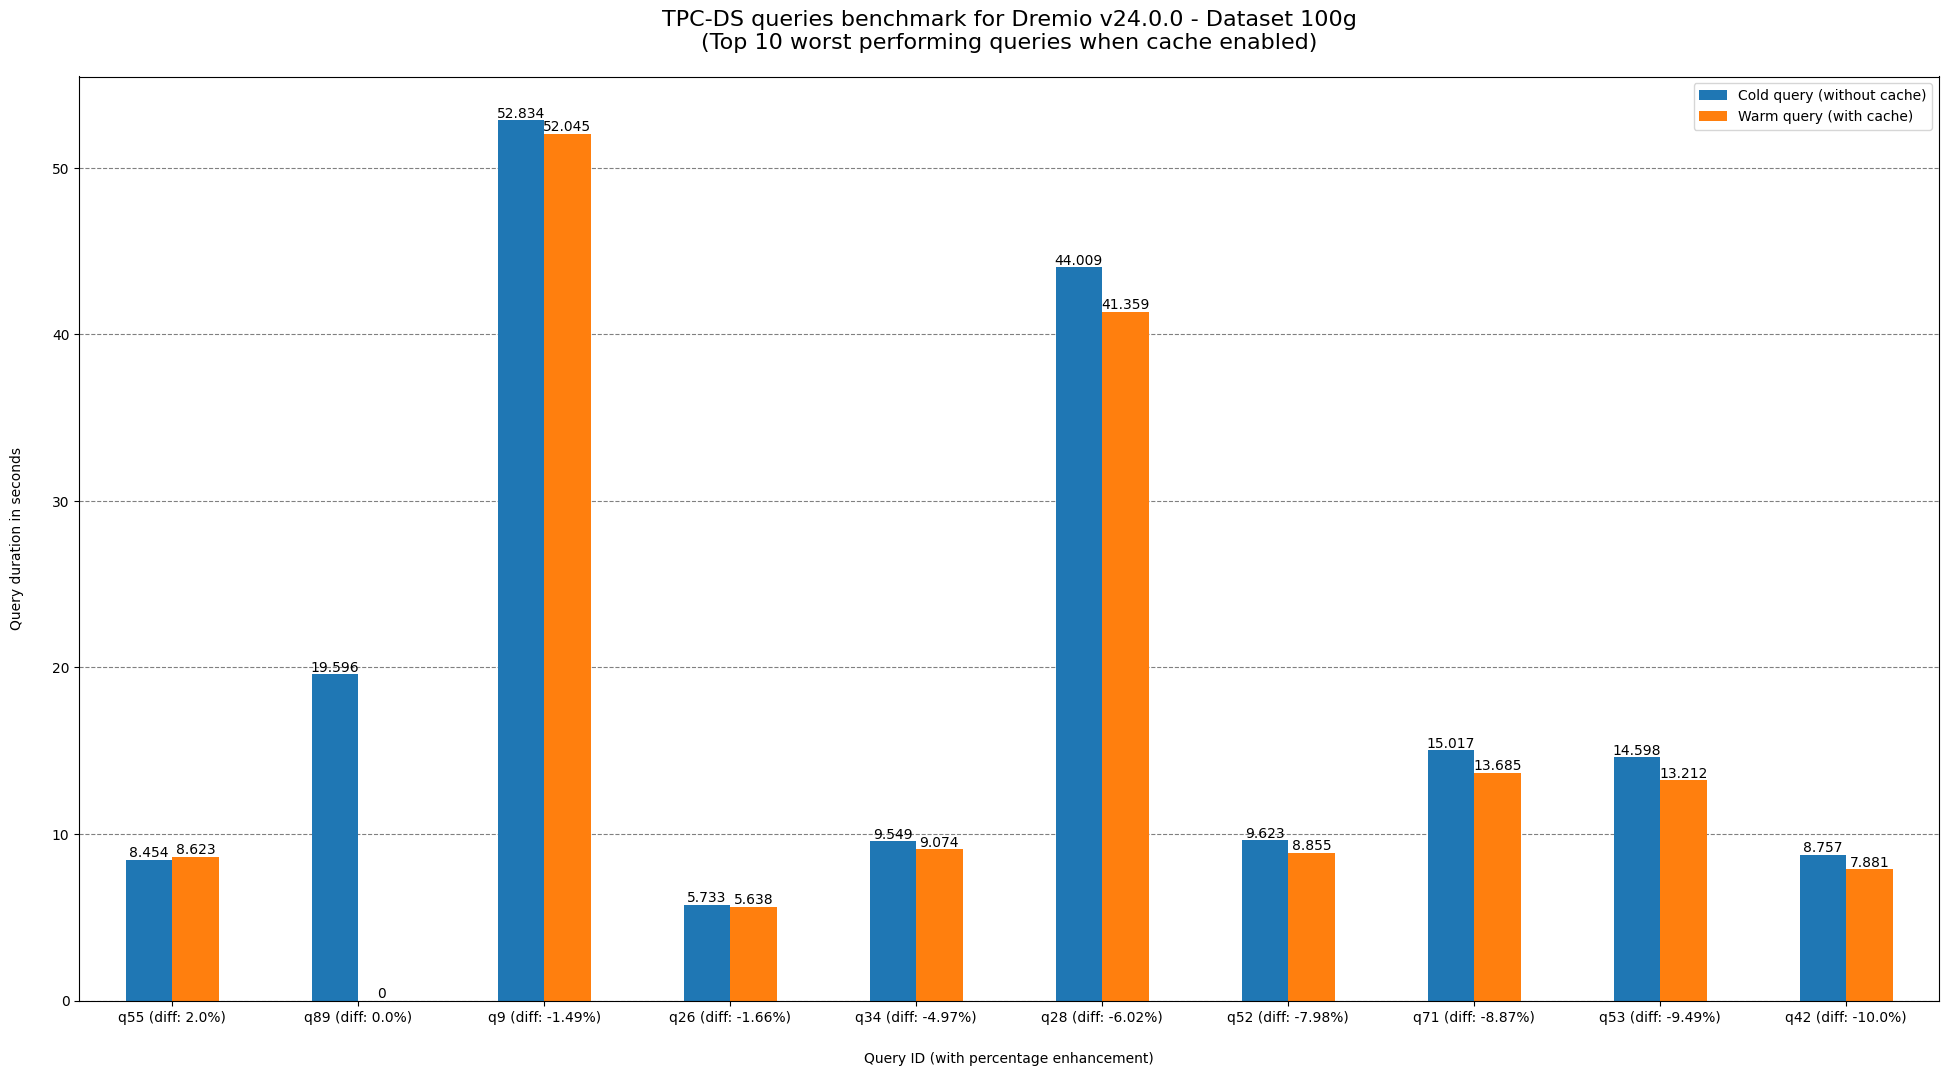

In [31]:
#------------------------------------------#
# Plot the worst 10 queries by using cache #
#------------------------------------------#

worst_queries_df = df_cleaned.nlargest(10, 'duration_diff_pct')
worst_queries = worst_queries_df.plot.bar(y=['duration_cold_sec', 'duration_warm_sec'], x='label_diff_pct', rot=0, figsize=(24, 12))
worst_queries.legend(["Cold query (without cache)", "Warm query (with cache)"])
worst_queries.yaxis.grid(color='gray', linestyle='dashed')
worst_queries.set_axisbelow(True)
worst_queries.set_title(f'{plot_main_title}\n(Top 10 worst performing queries when cache enabled)', pad=20, size=16)
worst_queries.set_xlabel('Query ID (with percentage enhancement)', labelpad=20)
worst_queries.set_ylabel('Query duration in seconds', labelpad=20)
for container in worst_queries.containers:
    worst_queries.bar_label(container)